In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms

In [2]:
class Attack(object):
    def __init__(self, net, criterion):
        self.net = net
        self.criterion = criterion

    def fgsm(self, x, y, targeted=False, eps=0.03, x_val_min=-1, x_val_max=1):
        x_adv = x.cuda().requires_grad_(True)
        h_adv = self.net(x_adv)
        self.net.zero_grad()
        if x_adv.grad is not None:
            x_adv.grad.data.fill_(0)
        if targeted:
            cost = self.criterion(h_adv, y.cuda())
        else:
            cost = -self.criterion(h_adv, y.cuda())

        cost.backward()

        x_adv.grad.sign_()
        x_adv = x_adv - eps*x_adv.grad
        x_adv = torch.clamp(x_adv, x_val_min, x_val_max)


        h = self.net(x.cuda())
        h_adv = self.net(x_adv)

        return x_adv, h_adv, h

    def i_fgsm(self, x, y, targeted=False, eps=0.03, alpha=1, iteration=1, x_val_min=-1, x_val_max=1):
        x_adv = Variable(x.data, requires_grad=True)
        for i in range(iteration):
            h_adv = self.net(x_adv)
            if targeted:
                cost = self.criterion(h_adv, y)
            else:
                cost = -self.criterion(h_adv, y)

            self.net.zero_grad()
            if x_adv.grad is not None:
                x_adv.grad.data.fill_(0)
            cost.backward()

            x_adv.grad.sign_()
            x_adv = x_adv - alpha*x_adv.grad
            x_adv = torch.clamp(x_adv, x-eps, x+eps)
            x_adv = torch.clamp(x_adv, x_val_min, x_val_max)
            x_adv = Variable(x_adv.data, requires_grad=True)

        h = self.net(x)
        h_adv = self.net(x_adv)

        return x_adv, h_adv, h

In [3]:
def imshow(img):
    npimg = img.numpy()
    npimg = npimg / 2 + 0.5     # unnormalize
    plt.figure(figsize=(2,2))
    plt.imshow(npimg.reshape(npimg.shape[1: 3]), cmap='gray')
    plt.show()

In [4]:
def test(model, test_loader, att_fn, eps=0.3):
    model.eval()
    correct = 0
    pred_correct = 0 # normal pred same as ground truth
    for idx, (data, target) in enumerate(test_loader):
        data, target = data.to('cuda'), target.to('cuda')
        x_adv, h_adv, h = att_fn(data, target, eps=eps)
        norm_pred = h.max(1, keepdim=True)[1].view(-1)
        adv_pred = h_adv.max(1, keepdim=True)[1].view(-1)
        pred_truth = norm_pred.eq(target)
        pred_correct += pred_truth.sum().item()
        correct += (pred_truth * norm_pred.eq(adv_pred)).sum().item()
        if (idx+1) % 100 == 0:
            print('Test Accuracy: {}/{} ({:.6f}%)'.format(
                correct, pred_correct,
                100. * correct / pred_correct))

    print('Final Results\nPred Correct: {}, Correct: {}, Total: {}, \nTest Accuracy: {}/{} ({:.6f}%), \nAttack Succ: {}/{} ({:.6f}%)\n'.format(
        pred_correct, correct, len(test_loader.dataset),
        pred_correct, len(test_loader.dataset),
        100. * pred_correct / len(test_loader.dataset),
        pred_correct-correct, pred_correct,
        100. * (pred_correct-correct) / pred_correct))

# FGSM

In [5]:
dataroot = 'D:/Lab/dataset'
model_file = './models/model2.md'

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)    

model = torch.load(model_file)

print(model)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


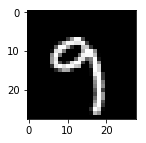

tensor([9])


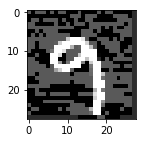

Normal Pred: 9, Adv. Pred: 9


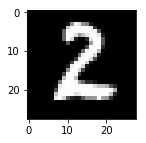

tensor([2])


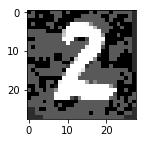

Normal Pred: 2, Adv. Pred: 2


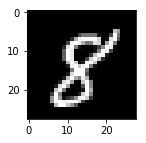

tensor([8])


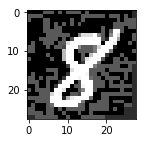

Normal Pred: 8, Adv. Pred: 3


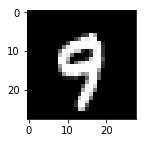

tensor([9])


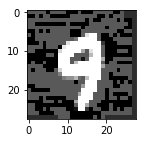

Normal Pred: 9, Adv. Pred: 9


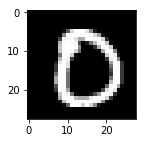

tensor([0])


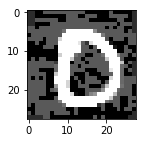

Normal Pred: 0, Adv. Pred: 0


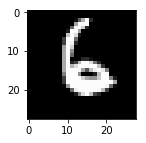

tensor([6])


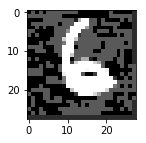

Normal Pred: 6, Adv. Pred: 6


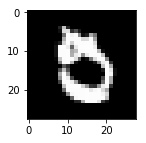

tensor([5])


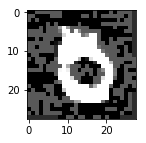

Normal Pred: 0, Adv. Pred: 0


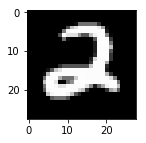

tensor([2])


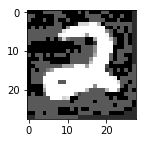

Normal Pred: 2, Adv. Pred: 2


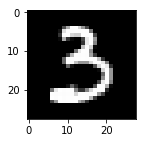

tensor([3])


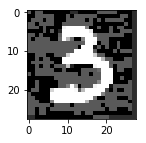

Normal Pred: 3, Adv. Pred: 3


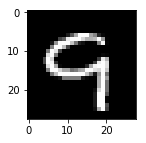

tensor([9])


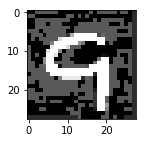

Normal Pred: 9, Adv. Pred: 5


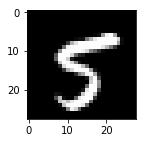

tensor([5])


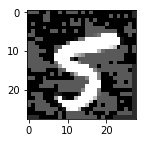

Normal Pred: 5, Adv. Pred: 5


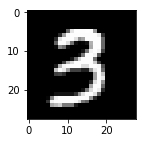

tensor([3])


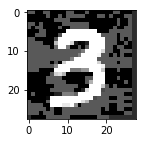

Normal Pred: 3, Adv. Pred: 3


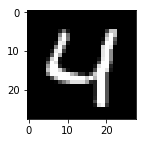

tensor([4])


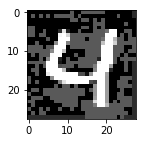

Normal Pred: 4, Adv. Pred: 4


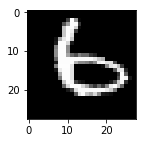

tensor([6])


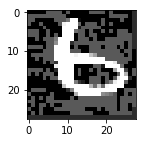

Normal Pred: 6, Adv. Pred: 6


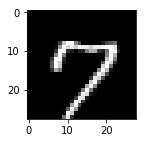

tensor([7])


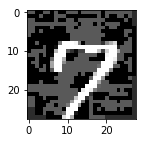

Normal Pred: 7, Adv. Pred: 9


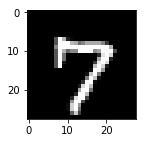

tensor([7])


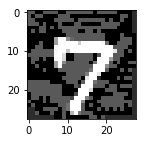

Normal Pred: 7, Adv. Pred: 7


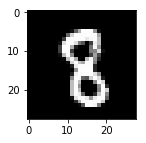

tensor([8])


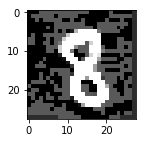

Normal Pred: 8, Adv. Pred: 8


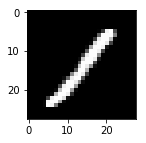

tensor([1])


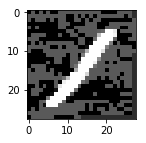

Normal Pred: 1, Adv. Pred: 1


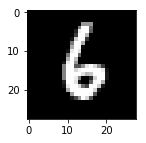

tensor([6])


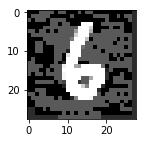

Normal Pred: 6, Adv. Pred: 6


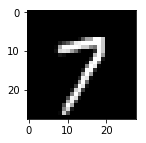

tensor([7])


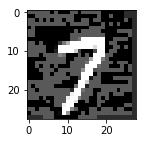

Normal Pred: 7, Adv. Pred: 7


In [6]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(dataroot, train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1, shuffle=True)

# get some random training images
dataiter = iter(test_loader)
for _ in range(20):
    image, label = dataiter.next()

    imshow(image[0])
    print(label)

    att = Attack(model, F.nll_loss)
    x_adv, h_adv, h = att.fgsm(image, label, eps=0.3)

    imshow(x_adv[0].cpu().detach())
    norm_pred = h.max(1, keepdim=True)[1].cpu().numpy().reshape(1)[0]
    adv_pred = h_adv.max(1, keepdim=True)[1].cpu().numpy().reshape(1)[0]

    print('Normal Pred: {}, Adv. Pred: {}'.format(norm_pred, adv_pred))

In [10]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(dataroot, train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=512, shuffle=True)

test(model, test_loader, att.fgsm, eps=0.3)

Final Results
Pred Correct: 9845, Correct: 7051, Total: 10000, 
Test Accuracy: 9845/10000 (98.450000%), 
Attack Succ: 2794/9845 (28.379888%)



In [11]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(dataroot, train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=512, shuffle=True)

test(model, test_loader, att.fgsm, eps=0.5)

Final Results
Pred Correct: 9845, Correct: 2981, Total: 10000, 
Test Accuracy: 9845/10000 (98.450000%), 
Attack Succ: 6864/9845 (69.720670%)



In [12]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(dataroot, train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=512, shuffle=True)

test(model, test_loader, att.fgsm, eps=0.8)

Final Results
Pred Correct: 9845, Correct: 570, Total: 10000, 
Test Accuracy: 9845/10000 (98.450000%), 
Attack Succ: 9275/9845 (94.210259%)

